This notebook is part of the $\omega radlib$  documentation: https://docs.wradlib.org.

Copyright (c) 2018, $\omega radlib$  developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Match spaceborn SR (GPM/TRMM) with ground radars GR

The idea is to match ground radar (GR) and space-born radar (SR) measurements in order to create spatially and temporally coicident samples without interpolation. The procedure had been suggested by [Schwaller and Morris (2011)](https://doi.org/10.1175/2010JTECHA1403.1) and is based on the adaption by [Warren, et. al. (2017)](https://doi.org/10.1175/JTECH-D-17-0128.1). 

The basic principle is illustrated in Fig. 2 of the original paper of Schwaller and Morris (2011):

![figure 2](fig2_schwaller_morris_2011.png)

*Quote Warren, et.al: "[...] In this approach, intersections between indi vidual SR beams and GR elevation sweeps are identified and the reflectivity values from both  instruments are averaged within a spatial neighborhood around the
intersection. Specifically, SR data are averaged in range over the width of the GR beam at the GR range of the intersection, while GR data are averaged in the
range–azimuth plane within the footprint of the SR beam. The result is a pair of reflectivity measurements corresponding to approximately the same volume of
atmosphere. [...]".*

This becomes clearer in Fig. 3:
![figure 3](fig3_schwaller_morris_2011.png)

Schwaller, MR, and Morris, KR. 2011. A ground validation network for the Global Precipitation Measurement mission. J. Atmos. Oceanic Technol., 28, 301-319.

Warren, R.A., A. Protat, S.T. Siems, H.A. Ramsay, V. Louf, M.J. Manton, and T.A. Kane, 0: Calibrating ground-based radars against TRMM and GPM. J. Atmos. Oceanic Technol., 0,

## Conventions

This code is based on the following conventions:

- `gr` indicates **g**round **r**adar
- `sr` indicates **s**pace-born precipitation **r**adar (TRMM or GPM)

The base routines are designed to process one GR sweep at a time. If a full GR volume with `nelev` of sweeps is available, you can iterate over each sweep. In this code, `ee` is an index that points to one of the `nelev` sweeps/elevation angles. Accordingly, a **GR** data set will be organised as an array of shape `(nelev_gr, nray_gr, ngate_gr)`.

A **SR** data set is typically organised as arrays with dimensions `(nscan_sr, nray_sr, ngate_sr)`.

*Please note*: the GR and SR datasets are managed by using convenience functions from the module file `io_func.py` located in the same directory as this notebook. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.cm as cm
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import datetime as dt
from osgeo import osr

In [2]:
# define GPM data set
gpm_file = wrl.util.get_wradlib_data_file('gpm/2A-CS-151E24S154E30S.GPM.Ku.V7-20170308.20141206-S095002-E095137.004383.V05A.HDF5')
# define matching ground radar file
gr2gpm_file = wrl.util.get_wradlib_data_file('hdf5/IDR66_20141206_094829.vol.h5')

# define TRMM data sets
trmm_2a23_file = wrl.util.get_wradlib_data_file('trmm/2A-CS-151E24S154E30S.TRMM.PR.2A23.20100206-S111425-E111526.069662.7.HDF')
trmm_2a25_file = wrl.util.get_wradlib_data_file('trmm/2A-CS-151E24S154E30S.TRMM.PR.2A25.20100206-S111425-E111526.069662.7.HDF')

# define matching ground radar file
gr2trmm_file = wrl.util.get_wradlib_data_file('hdf5/IDR66_20100206_111233.vol.h5')

In [3]:
# Space-born precipitation radar parameters
sr_pars = {"trmm": {
    "zt": 402500.,  # orbital height of TRMM (post boost)   APPROXIMATION!
    "dr": 250.,     # gate spacing of TRMM
    "gr_file": gr2trmm_file,
}, "gpm": {
    "zt": 407000.,  # orbital height of GPM                 APPROXIMATION!
    "dr": 125.,      # gate spacing of GPM
    "gr_file": gr2gpm_file,
}}

In [4]:
# Set parameters for this procedure
bw_sr = 0.71                  # SR beam width
platf = "gpm"                 # SR platform/product: one out of ["gpm", "trmm"]
zt = sr_pars[platf]["zt"]     # SR orbit height (meters)
dr_sr = sr_pars[platf]["dr"]  # SR gate length (meters)
gr_file = sr_pars[platf]["gr_file"]
ee = 2                        # Index that points to the GR elevation angle to be used

## Data Input

### Read and organize the GR data

The following code reads data in ODIM H5 format. If your GR data is in some other format respective adaptions are needed.

In [5]:
def _get_tilts(dic):
    i = 0
    for k in dic.keys():
        if 'dataset' in k:
            i += 1
    return i


def read_gr(filename, loaddata=True):

    gr_data = wrl.io.read_generic_netcdf(filename)
    dat = gr_data['what']['date']
    tim = gr_data['what']['time']
    date = dt.datetime.strptime(dat + tim, "%Y%d%m%H%M%S")
    source = gr_data['what']['source']

    lon = gr_data['where']['lon']
    lat = gr_data['where']['lat']
    alt = gr_data['where']['height']

    if gr_data['what']['object'] == 'PVOL':
        ntilt = _get_tilts(gr_data)
    else:
        raise ValueError('GR file is no PPI/Volume File')

    ngate = np.zeros(ntilt, dtype=np.int16)
    nbeam = np.zeros(ntilt)
    elang = np.zeros(ntilt)
    r0 = np.zeros(ntilt)
    dr = np.zeros(ntilt)
    a0 = np.zeros(ntilt)

    for i in range(0, ntilt):
        dset = gr_data['dataset{0}'.format(i+1)]
        a0[i] = dset['how']['astart']
        elang[i] = dset['where']['elangle']
        ngate[i] = dset['where']['nbins']
        r0[i] = dset['where']['rstart']
        dr[i] = dset['where']['rscale']
        nbeam[i] = dset['where']['nrays']

    if ((len(np.unique(r0)) != 1) |
            (len(np.unique(dr)) != 1) |
            (len(np.unique(a0)) != 1) |
            (len(np.unique(nbeam)) != 1) |
            (nbeam[0] != 360)):
        raise ValueError('GroundRadar Data layout dos not match')

    gr_dict = {}
    gr_dict.update({'source': source, 'date': date, 'lon': lon, 'lat': lat,
                    'alt': alt, 'ngate': ngate, 'nbeam': nbeam, 'ntilt': ntilt,
                    'r0': r0, 'dr': dr, 'a0': a0, 'elang': elang})
    if not loaddata:
        return gr_dict

    sdate = []
    refl = []
    for i in range(0, ntilt):
        dset = gr_data['dataset{0}'.format(i+1)]
        dat = dset['what']['startdate']
        tim = dset['what']['starttime']
        date = dt.datetime.strptime(dat + tim, "%Y%d%m%H%M%S")
        sdate.append(date)
        data = dset['data1']
        quantity = data['what']['quantity']
        factor = data['what']['gain']
        offset = data['what']['offset']
        if quantity == 'DBZH':
            dat = data['variables']['data']['data'] * factor + offset
            refl.append(dat)

    sdate = np.array(sdate)
    refl = np.array(refl)

    gr_dict.update({'sdate': sdate, 'refl': refl})

    return gr_dict

In [6]:
# read matching GR data
gr_data = read_gr(gr_file)

## Data handling

### Extract relevant GR data and meta-data

In [7]:
# number of rays in gr sweep
nray_gr = gr_data['nbeam'].astype("i4")[ee]
# number of gates in gr beam
ngate_gr = gr_data['ngate'].astype("i4")[ee]
# number of sweeps
nelev = gr_data['ntilt']
# elevation of sweep (degree)
elev_gr = gr_data['elang'][ee]
# gate length (meters)
dr_gr = gr_data['dr'][ee]
# reflectivity array of sweep
ref_gr = gr_data['refl'][ee]
# sweep datetime stamp
date_gr = gr_data['sdate'][ee]
# range of first gate
r0_gr = gr_data['r0'][ee]                    
# azimuth angle of first beam
a0_gr = gr_data['a0'][ee]
# Longitude of GR
lon0_gr = gr_data['lon']
# Latitude of GR
lat0_gr = gr_data['lat']
# Altitude of GR (meters)
alt0_gr = gr_data['alt']
# Beam width of GR (degree)
bw_gr = 1.
print(elev_gr, lon0_gr)

1.2999999523162842 153.24000549316406


### Calculate GR Bounding Box

In [8]:
coord = wrl.georef.sweep_centroids(nray_gr, dr_gr, ngate_gr, elev_gr)
coords = wrl.georef.spherical_to_proj(coord[..., 0], 
                                      coord[..., 1],
                                      coord[..., 2], 
                                      (lon0_gr, lat0_gr, alt0_gr))
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]
bbox = wrl.zonalstats.get_bbox(lon, lat)
print("Radar bounding box:\n\t%.2f\n%.2f           %.2f\n\t%.2f" % 
      (bbox['top'], bbox['left'], bbox['right'], bbox['bottom']))

Radar bounding box:
	-26.37
151.72           154.76
	-29.07


### Read and organize the SR data

In [9]:
# read spaceborn SR data
if platf == "gpm":
    sr_data = wrl.io.read_gpm(gpm_file, bbox)
elif platf == "trmm":
    sr_data = wrl.io.read_trmm(trmm_2a23_file, trmm_2a25_file, bbox)
else:
    raise("Invalid platform")

In [10]:
refl = sr_data['refl']
print(refl)


[[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 ...

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [15.90999984741211 15.930000305175781 15.920000076293945 ... -- -- --]
  [-- 15.0 15.020000457763672 ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]

### Extract relevant SR data and meta-data

In [11]:
# Longitudes of SR scans
sr_lon = sr_data['lon']
# Latitudes of SR scans
sr_lat = sr_data['lat']
# Precip flag
pflag = sr_data['pflag']
# Number of scans on SR data
nscan_sr= sr_data['nscan']
# Number of rays in one SR scan
nray_sr = sr_data['nray']
# Number of gates in one SR ray
ngate_sr = sr_data['nbin']

In [12]:
print(sr_lon.shape)

(82, 49)


## Georeferencing

### Set fundamental georeferencing parameters

In [13]:
# Calculate equivalent earth radius
wgs84 = wrl.georef.get_default_projection()
re1 = wrl.georef.get_earth_radius(lat0_gr, wgs84) 
print("Earth radius 1:", re1)
a = wgs84.GetSemiMajor()
b = wgs84.GetSemiMinor()
print("SemiMajor, SemiMinor:", a, b)

# Set up aeqd-projection gr-centered
rad = wrl.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' + 
                                   '+lat_0={lat:f} +a={a:f} ' +
                                   '+b={b:f}').format(lon=lon0_gr,
                                                      lat=lat0_gr,
                                                      a=a, b=b))
re2 = wrl.georef.get_earth_radius(lat0_gr, rad)
print("Earth radius 2:", re2)


Earth radius 1: 6373541.039814419
SemiMajor, SemiMinor: 6378137.0 6356752.314245179
Earth radius 2: 6373541.039814381


### Georeference GR data

In [14]:
# create gr range and azimuth arrays
rmax_gr = r0_gr + ngate_gr * dr_gr
r_gr = np.arange(0, ngate_gr) * dr_gr + dr_gr/2.
az_gr = np.arange(0, nray_gr) - a0_gr
print("Range/Azi-Shape:", r_gr.shape, az_gr.shape)

# create gr polar grid and calculate aeqd-xyz coordinates
gr_polargrid = np.meshgrid(r_gr, az_gr)
gr_xyz, rad = wrl.georef.spherical_to_xyz(gr_polargrid[0], gr_polargrid[1], elev_gr, (lon0_gr, lat0_gr, alt0_gr ), 
                                          squeeze=True)
print("XYZ-Grid-Shape:", gr_xyz.shape)

# create gr poygon array in aeqd-xyz-coordinates
gr_poly, rad1 = wrl.georef.spherical_to_polyvert(r_gr, az_gr, elev_gr, (lon0_gr, lat0_gr, alt0_gr))
print(gr_poly.shape, 360 * 600)
gr_poly.shape = (nray_gr, ngate_gr, 5, 3)

# get radar domain (outer ring)
gr_domain = gr_xyz[:,-1,0:2]
gr_domain = np.vstack((gr_domain, gr_domain[0]))
print("Domain-Shape:", gr_domain.shape)

Range/Azi-Shape: (600,) (360,)
XYZ-Grid-Shape: (360, 600, 3)
(216000, 5, 3) 216000
Domain-Shape: (361, 2)


### Georeference SR data

In [15]:
sr_x, sr_y = wrl.georef.reproject(sr_lon, sr_lat, 
                                      projection_source=wgs84, 
                                      projection_target=rad)
sr_xy = np.dstack((sr_x, sr_y))
print("SR-GRID-Shapes:", sr_x.shape, sr_y.shape, sr_xy.shape)

SR-GRID-Shapes: (82, 49) (82, 49) (82, 49, 2)


### Subset relevant SR data

(82, 49, 2)
(82, 49)


(82, 49) (82, 49, 2)
(82, 49) (4018, 2)


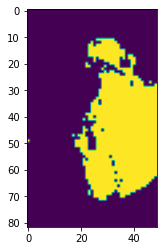

In [16]:
# Create ZonalData for spatial subsetting (inside GR range domain)

# get precip indexes
print(sr_xy.shape)
print(pflag.shape)

precip_mask = (pflag == 2) & wrl.zonalstats.get_clip_mask(sr_xy, gr_domain, rad)

# get iscan/iray boolean arrays
print(precip_mask.shape, sr_xy.shape)
print(pflag.shape, sr_xy.reshape(-1, sr_xy.shape[-1]).shape)
pl.imshow(precip_mask)

### SR Parallax Correction

In [17]:
print("NRAY", nray_sr)
print("NBIN", ngate_sr)

# use localZenith Angle
alpha = sr_data['zenith']
beta = abs(-17.04 + np.arange(nray_sr) * bw_sr)

# Correct for parallax, get 3D-XYZ-Array
#   xyzp_sr: Parallax corrected xyz coordinates
#   r_sr_inv: range array from ground to SR platform
#   zp: SR bin altitudes
xyp_sr, r_sr_inv, z_sr = wrl.georef.correct_parallax(sr_xy, ngate_sr, dr_sr, alpha)
print(xyp_sr.shape, r_sr_inv.shape, z_sr.shape)
xyzp_sr = np.concatenate((xyp_sr, z_sr[..., np.newaxis]),
                   axis=-1)
print(sr_xy.shape)
print("SR_XYP:", xyp_sr.shape, xyzp_sr.shape, r_sr_inv.shape, z_sr.shape)

NRAY 49
NBIN 176


(82, 49, 176, 2) (176,) (82, 49, 176)
(82, 49, 2)
SR_XYP: (82, 49, 176, 2) (82, 49, 176, 3) (176,) (82, 49, 176)


### Compute spherical coordinates of SR bins with regard to GR

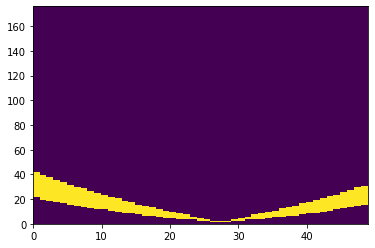

In [18]:
r_sr, az_sr, elev_sr = wrl.georef.xyz_to_spherical(xyzp_sr, alt0_gr, proj=rad)    
#TODO: hardcoded 1.0
mask = (elev_sr > (1.0 - bw_gr/2.)) & (elev_sr < (1.0 + bw_gr/2.))
pl.figure()
pl.pcolormesh(mask[40,:,:].T)

### Compute SR and GR pulse volumes

#### Calculate distance from orbit $r_s$

In [19]:
rs = wrl.georef.dist_from_orbit(zt, alpha, beta, r_sr_inv, re1)

#### SR pulse volume

In [20]:
# Small anngle approximation
vol_sr2  = np.pi * dr_sr * rs**2 * np.radians(bw_sr / 2.)**2

# Or using wradlib's native function
vol_sr = wrl.qual.pulse_volume(rs, dr_sr, bw_sr)
# Evaluate difference between both approaches
print("Min. difference (m3):", (vol_sr - vol_sr2).min())
print("Max. difference (m3): ", (vol_sr - vol_sr2).max())
print("Average rel. difference (%):", round(np.mean(vol_sr-vol_sr2)*100./np.mean(np.mean(vol_sr2)), 4))

# Verdict: differences are negligble - use wradlibs's native function!

Min. difference (m3): 57223.421278476715
Max. difference (m3):  70339.5594573021
Average rel. difference (%): 0.0026


#### GR pulse volume

In [21]:
# GR pulse volumes
#   along one beam
vol_gr = wrl.qual.pulse_volume(r_gr, dr_gr, bw_gr)
#   with shape (nray_gr, ngate_gr)
vol_gr = np.repeat(vol_gr, nray_gr).reshape((nray_gr, ngate_gr), order="F")

#### Calculate horizontal and vertical dimensions $R_s$ and $D_s$ of SR bins

In [22]:
Rs = 0.5 * (1 +  np.cos(np.radians(alpha)))[:,:,np.newaxis] * rs * np.tan(np.radians(bw_sr/2.))
Ds = dr_sr / np.cos(np.radians(alpha))
Ds = np.broadcast_to(Ds[..., np.newaxis], Rs.shape)

### Median Brightband Width/Height

In [23]:
print(z_sr.shape)
print(sr_data['zbb'].shape, sr_data['bbwidth'].shape, sr_data['quality'].shape)
ratio, ibb = wrl.qual.get_bb_ratio(sr_data['zbb'], sr_data['bbwidth'], sr_data['quality'], z_sr)
print(ratio.shape)
zbb = sr_data['zbb'].copy()
zbb[~ibb] = np.nan
print(np.nanmin(ratio[..., 9]), np.nanmax(ratio[..., 9]))
#pl.imshow(ratio, vmin=-10, vmax=30)

(82, 49, 176)
(82, 49) (82, 49) (82, 49)
(82, 49, 176)
-4.183126378193563 -4.0904391409528404


### Convert SR Ku reflectivities to S-band 

Based on [Cao et.al (2013)](https://doi.org/10.1002/jgrd.50138)

In [24]:
ref_sr = sr_data['refl'].filled(np.nan)
print(ref_sr.shape, ratio.shape)
ref_sr_ss = np.zeros_like(ref_sr) * np.nan
ref_sr_sh = np.zeros_like(ref_sr) * np.nan

a_s, a_h = (wrl.trafo.KuBandToS.snow, wrl.trafo.KuBandToS.hail) 

ia = (ratio >= 1)
ref_sr_ss[ia] = ref_sr[ia] + wrl.util.calculate_polynomial(ref_sr[ia], a_s[:,10])
ref_sr_sh[ia] = ref_sr[ia] + wrl.util.calculate_polynomial(ref_sr[ia], a_h[:,10])
ib = (ratio <= 0)
ref_sr_ss[ib] = ref_sr[ib] + wrl.util.calculate_polynomial(ref_sr[ib], a_s[:,0])
ref_sr_sh[ib] = ref_sr[ib] + wrl.util.calculate_polynomial(ref_sr[ib], a_h[:,0])
im = (ratio > 0) & (ratio < 1)
ind = np.round(ratio[im] * 10).astype(np.int)
ref_sr_ss[im] = ref_sr[im] + wrl.util.calculate_polynomial(ref_sr[im], a_s[:,ind])
ref_sr_sh[im] = ref_sr[im] + wrl.util.calculate_polynomial(ref_sr[im], a_h[:,ind])

# Jackson Tan's fix for C-band
is_cband = False
if (is_cband):
    deltas = (ref_sr_ss - ref_sr) * 5.3 / 10.0
    ref_sr_ss = outref_sr + deltas
    deltah = (ref_sr_sh - ref_sr) * 5.3 / 10.0
    ref_sr_sh = ref_sr + deltah

ref_sr_ss[ref_sr < 0] = np.nan

(82, 49, 176) (82, 49, 176)


### Convert S-band GR reflectivities to Ku-band

Using the method of [Liao and Meneghini (2009)](https://doi.org/10.1175/2008JAMC1974.1)

In [25]:
# Convert S-band GR reflectivities to Ku-band using method of Liao and Meneghini (2009)
ref_gr_ku = np.zeros_like(ref_gr) * np.nan

# Which zbb value should we take here???
#    Q'n'Dirty: just take the mean of all SR profiles
#    TODO: Consider zbb for each profile during the matching process

# Snow
ia = ( gr_xyz[...,2] >= np.nanmean(zbb) )
#ref_gr_ku[ia] = wrl.trafo.KuBandToS.snow[0] + wrl.trafo.KuBandToS.snow[1]*ref_gr[ia] + wrl.trafo.KuBandToS.snow[2]*ref_gr[ia]**2
ref_gr_ku[ia] = wrl.util.calculate_polynomial(ref_gr[ia], wrl.trafo.SBandToKu.snow)
# Rain
ib = ( gr_xyz[...,2] < np.nanmean(zbb) )
#ref_gr_ku[ib] = wrl.trafo.KuBandToS.rain[0] + wrl.trafo.KuBandToS.rain[1]*ref_gr[ia] + wrl.trafo.KuBandToS.rain[2]*ref_gr[ia]**2
ref_gr_ku[ib] = wrl.util.calculate_polynomial(ref_gr[ib], wrl.trafo.SBandToKu.rain)

# Jackson Tan's fix for C-band
is_cband = False
if (is_cband):
    delta = (ref_gr_ku - ref_gr) * 5.3/10.0
    ref_gr_ku = ref_gr + delta

## Matching SR/GR

### Identify which SR rays actually intersect with the GR sweep

Based on the above criteria (in radar range, precipitating SR profile) and based on SR elevation angle (with regard to GR).

In [26]:
# First assumption: no valid SR bins (all False)
valid = np.asarray(elev_sr, dtype=np.bool)==False
print(valid.shape, precip_mask.shape)
# SR is inside GR range and is precipitating
iscan = precip_mask.nonzero()[0]
iray = precip_mask.nonzero()[1]
valid[iscan,iray] = True
# SR bins intersect with GR sweep
valid = valid & (elev_sr >= (elev_gr-bw_gr/2.)) & (elev_sr <= (elev_gr+bw_gr/2.))
# Number of matching SR bins per profile
nvalids = np.sum(valid, axis=2)
# scan and ray indices for profiles with at least one valid bin
vscan, vray = np.where(nvalids>0)
# number of profiles with at least one valid bin
nprof = len(vscan)
print(vscan.shape)
print(valid.shape)


(82, 49, 176) (82, 49)


(1218,)
(82, 49, 176)


#### Averaging SR parameters

(82, 49, 176, 3)


(1218, 3) (82, 49)


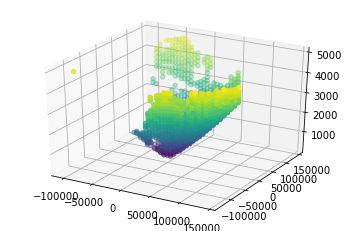

In [27]:
# average coordinates
xyz_v1 = xyzp_sr.copy()
print(xyz_v1.shape)
xyz_v1[~valid] = np.nan
xyz_c1 = xyzp_sr.filled(0)
xyz_c1[~valid] = 0
c = np.count_nonzero(xyz_c1[..., 0], axis=2)
ntotsr = c[vscan, vray]
xyz_m1 = np.nanmean(xyz_v1,axis=2)
xyz = xyz_m1[vscan, vray]
print(xyz.shape, c.shape)

# approximate Rs 
rs_v1 = Rs.copy()
rs_v1[~valid] = np.nan
rs_m1 = np.nanmax(rs_v1, axis=2)
rs_prof = rs_m1[vscan, vray]
ds = rs_prof

# approximate Ds
ds_v1 = Ds.copy()
ds_v1[~valid] = np.nan
ds_m1 = np.nansum(ds_v1, axis=2)
ds_prof = ds_m1[vscan, vray]
dz = ds_prof

# approximate Vs
vs_v1 = vol_sr.copy()
vs_v1[~valid] = np.nan
vs_m1 = np.nansum(vs_v1, axis=2)
vs_prof = vs_m1[vscan, vray]
volsr1 = vs_prof

from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_m1[..., 0], xyz_m1[..., 1], xyz_m1[..., 2], c=c.ravel())

#### Calculate spherical coordinates of SR sample volume with respect to GR

In [28]:
r_sr, az_sr, el_rs = wrl.georef.xyz_to_spherical(xyz, alt0_gr, proj=rad)

#### Average SR reflectivity

In [29]:
ref_sr_1 = wrl.trafo.idecibel(ref_sr)
ref_sr_1[~valid] = np.nan
refsr1a = np.nanmean(ref_sr_1, axis=2)[vscan,vray]
refsr1a = wrl.trafo.decibel(refsr1a)

ref_sr_2 = wrl.trafo.idecibel(ref_sr_ss)
ref_sr_2[~valid] = np.nan
refsr2a = np.nanmean(ref_sr_2, axis=2)[vscan,vray]
refsr2a = wrl.trafo.decibel(refsr2a)

ref_sr_3 = wrl.trafo.idecibel(ref_sr_sh)
ref_sr_3[~valid] = np.nan
refsr3a = np.nanmean(ref_sr_3, axis=2)[vscan,vray]
refsr3a = wrl.trafo.decibel(refsr3a)


print(refsr1a.shape)

(1218,)


### Identify which GR bins actually intersect with the SR footprint

#### Create Zonal Data Source of matching SR profiles

In [30]:
zds = wrl.zonalstats.DataSource(xyz[:, 0:2].reshape(-1, 2), rad)
print(zds.ds.GetLayer().GetFeatureCount())

1218


#### Create SR beam polygons using $R_s$

In [31]:
tmp_trg_lyr = zds.ds.GetLayer()
trg_poly = []
for i, feat in enumerate(tmp_trg_lyr):
    geom = feat.GetGeometryRef().Buffer(rs_prof[i])
    poly = wrl.georef.ogr_to_numpy(geom)
    trg_poly.append(poly)

#### Create ZonalDataPoly for GR and SR profiles

In [32]:
#%%time
print("creating")
zdp = wrl.zonalstats.ZonalDataPoly(gr_poly[..., 0:2].reshape(-1, 5, 2), trg_poly, srs=rad)
zdp.dump_vector('m3d_zonal_poly_{0}'.format(platf))

creating


In [33]:
#%%time
print("loading")
obj3 = wrl.zonalstats.ZonalStatsPoly('m3d_zonal_poly_{0}'.format(platf))

loading


#### Average GR volume and reflectivity

In [34]:
#%%time
print(obj3.ix.shape)
volgr1 = np.array([np.sum(vol_gr.ravel()[obj3.ix[i]])
                   for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
print(volgr1.shape)

ref_gr_i = wrl.trafo.idecibel(ref_gr.ravel())
ref_gr_ku_i = wrl.trafo.idecibel(ref_gr_ku.ravel())
refgr1a = np.array([np.nanmean(ref_gr_i[obj3.ix[i]])
             for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
refgr1a = wrl.trafo.decibel(refgr1a)
refgr2a = np.array([np.nanmean(ref_gr_ku_i[obj3.ix[i]])
             for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
refgr2a = wrl.trafo.decibel(refgr2a)

(1218,)


(1218,)


## Diagnostic Plots

Text(0.5, 0.98, 'uncorrected GR vs uncorrected SR')

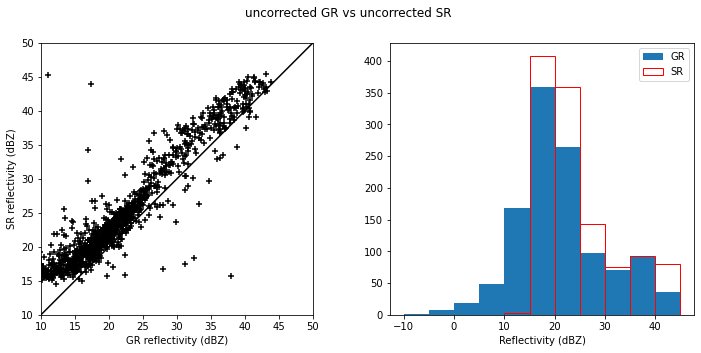

In [35]:
fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, aspect="equal")
pl.scatter(refgr1a, refsr1a, marker="+", c="black")
pl.plot([0,60],[0,60], linestyle="solid", color="black")
pl.xlim(10,50)
pl.ylim(10,50)
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
ax = fig.add_subplot(122)
pl.hist(refgr1a[refsr1a>10], bins=np.arange(-10,50,5), edgecolor="None", label="GR")
pl.hist(refsr1a[refsr1a>-10], bins=np.arange(-10,50,5), edgecolor="red", facecolor="None", label="SR")
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
fig.suptitle("uncorrected GR vs uncorrected SR")

Text(0.5, 0.98, 'corrected GR vs uncorrected SR')

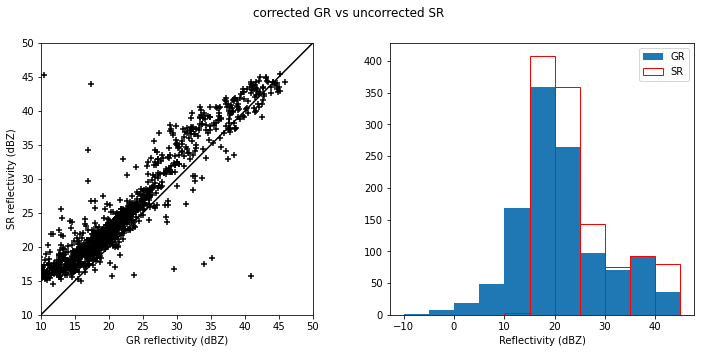

In [36]:
fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, aspect="equal")
pl.scatter(refgr2a, refsr1a, marker="+", c="black")
pl.plot([0,60],[0,60], linestyle="solid", color="black")
pl.xlim(10,50)
pl.ylim(10,50)
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
ax = fig.add_subplot(122)
pl.hist(refgr1a[refsr1a>10], bins=np.arange(-10,50,5), edgecolor="None", label="GR")
pl.hist(refsr1a[refsr1a>-10], bins=np.arange(-10,50,5), edgecolor="red", facecolor="None", label="SR")
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
fig.suptitle("corrected GR vs uncorrected SR")

Text(0.5, 0.98, 'corrected GR vs corrected SR snow')

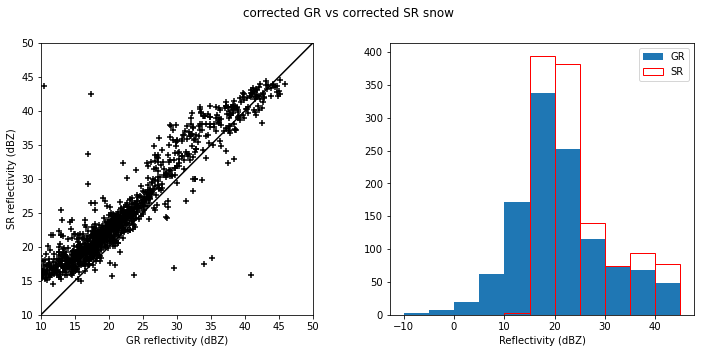

In [37]:
fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, aspect="equal")
pl.scatter(refgr2a, refsr2a, marker="+", c="black")
pl.plot([0,60],[0,60], linestyle="solid", color="black")
pl.xlim(10,50)
pl.ylim(10,50)
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
ax = fig.add_subplot(122)
pl.hist(refgr2a[refsr2a>10], bins=np.arange(-10,50,5), edgecolor="None", label="GR")
pl.hist(refsr2a[refsr2a>-10], bins=np.arange(-10,50,5), edgecolor="red", facecolor="None", label="SR")
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
fig.suptitle("corrected GR vs corrected SR snow")

Text(0.5, 0.98, 'corrected GR vs corrected SR hail')

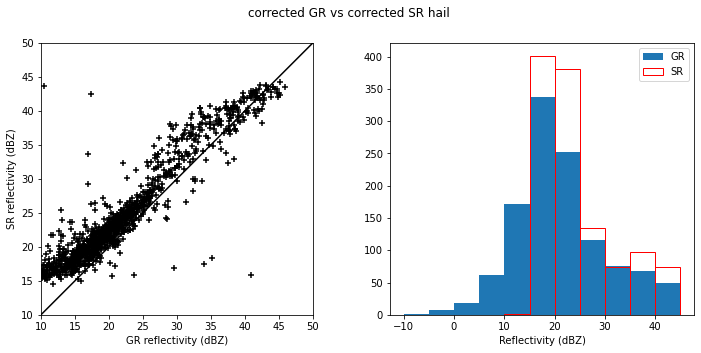

In [38]:
fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, aspect="equal")
pl.scatter(refgr2a, refsr3a, marker="+", c="black")
pl.plot([0,60],[0,60], linestyle="solid", color="black")
pl.xlim(10,50)
pl.ylim(10,50)
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
ax = fig.add_subplot(122)
pl.hist(refgr2a[refsr3a>10], bins=np.arange(-10,50,5), edgecolor="None", label="GR")
pl.hist(refsr3a[refsr3a>-10], bins=np.arange(-10,50,5), edgecolor="red", facecolor="None", label="SR")
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
fig.suptitle("corrected GR vs corrected SR hail")

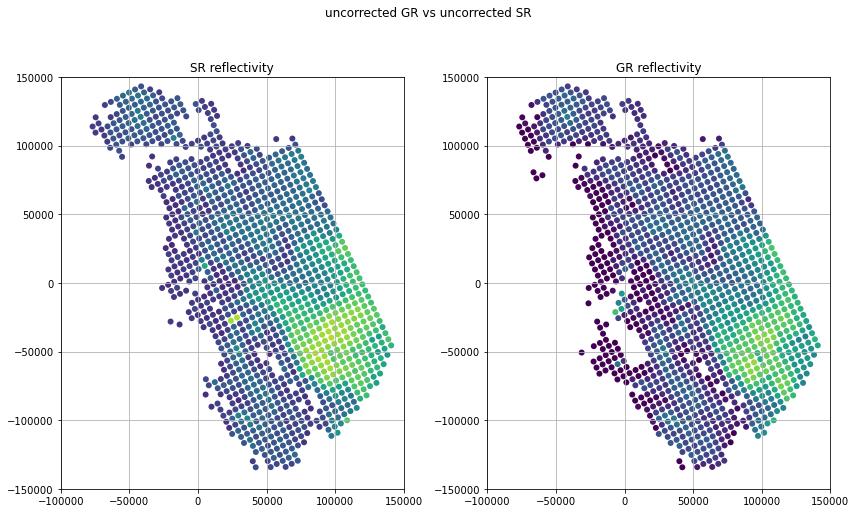

In [39]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(121, aspect="equal")
pl.scatter(xyz[..., 0], xyz[...,1], c=refsr1a, cmap=pl.cm.viridis, vmin=10, vmax=50, edgecolor="None")
pl.title("SR reflectivity")
pl.xlim(-100000, 150000)
pl.ylim(-150000, 150000)
pl.grid()
ax = fig.add_subplot(122, aspect="equal")
pl.scatter(xyz[..., 0], xyz[...,1], c=refgr1a, cmap=pl.cm.viridis, vmin=10, vmax=50, edgecolor="None")
pl.title("GR reflectivity")
pl.xlim(-100000, 150000)
pl.ylim(-150000, 150000)
pl.grid()
fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()

## Former Method using loop

In [40]:
# Lots of containers to store samples (only for one GR sweep angle!)
x = np.zeros(nprof)*np.nan        # x coordinate of sample
y = np.zeros(nprof)*np.nan        # y coordinate of sample
z = np.zeros(nprof)*np.nan        # z coordinate of sample
dz = np.zeros(nprof)*np.nan       # depth of sample
ds = np.zeros(nprof)*np.nan       # width of sample
rs = np.zeros(nprof)*np.nan       # range of sample from GR
refsr1 = np.zeros(nprof)*np.nan     # SR reflectivity
refsr2 = np.zeros(nprof)*np.nan     # SR reflectivity (S-band, snow)
refsr3 = np.zeros(nprof)*np.nan     # SR reflectivity (S-band, hail)  
refgr1 = np.zeros(nprof)*np.nan     # GR reflectivity
refgr2 = np.zeros(nprof)*np.nan     # GR reflectivity (Ku-band)
ntotpr = np.zeros(nprof,dtype="i4")# total number of SR bins in sample
nrej1 = np.zeros(nprof,dtype="i4")# number of rejected SR bins in sample
ntotgr = np.zeros(nprof,dtype="i4")# total number of GR bins in sample
nrej2 = np.zeros(nprof,dtype="i4")# number of rejected GR bins in sample
iref1 = np.zeros(nprof)*np.nan    # path-integrated SR reflectivity
iref2 = np.zeros(nprof)*np.nan    # path-integrated GR reflectivity
stdv1 = np.zeros(nprof)*np.nan    # std. dev. of SR reflectivity in sample
stdv2 = np.zeros(nprof)*np.nan    # std. dev. of GR reflectivity in sample
volsr = np.zeros(nprof)*np.nan     # total volume of SR bins in sample
volgr = np.zeros(nprof)*np.nan     # total volume of GR bins in sample

In [41]:
#%%time
# Loop over relevant SR profiles
for ii, (ss, rr)  in enumerate(zip(vscan,vray)):
    # Index and count valid bins in each profile
    ip = np.where(valid[ss,rr])[0]
    numbins = len(ip)
    ntotpr[ii]=numbins
    if numbins == 0:
        continue
    # Compute the mean position of these bins
    x[ii]=np.mean(xyzp_sr[ss,rr,ip,0])
    y[ii]=np.mean(xyzp_sr[ss,rr,ip,1])
    z[ii]=np.mean(xyzp_sr[ss,rr,ip,2])
    
    # Thickness of the layer
    dz[ii]=(numbins * dr_sr) / np.cos( np.radians(alpha[ss, rr]) )
    
    # SR averaging volume
    volsr[ii]=np.sum(vol_sr[ss, rr, ip])

    # Note mean TRMM beam diameter
    ds[ii]=np.radians(bw_sr) * np.mean( ( (zt-z[ii]) / 
                                         np.cos( np.radians(alpha[ss, rr]) ) ) )
    # Note distance from radar
    s=np.sqrt(x[ii]**2+y[ii]**2)
    rs[ii]=(re2+z[ii]) * np.sin(s/re2) / np.cos(np.radians(elev_gr))
    
    # This should not be required because we applied ZonalData
    ### Check that sample is within radar range
    ##if r[ii,jj]+ds[ii,jj]/2. gt rmax then continue

    ## THIS IS THE ORIGINAL IDL CODE - IS THIS A BUG???
    ##ref1[ii,jj]=MEAN(ref_sr1,/nan)
    ##ref3[ii,jj]=MEAN(ref_sr2,/nan)
    ##ref4[ii,jj]=MEAN(ref_sr3,/nan)
    
    # Simple linear average of reflectivity 
    #   - we can become fancier in the next step
    # ATTENTION: NEED TO FLIP ARRAY
    
    refsr1[ii]=np.nanmean(ref_sr[ss,rr,ip])
    refsr2[ii]=np.nanmean(ref_sr_ss[ss,rr,ip])
    refsr3[ii]=np.nanmean(ref_sr_sh[ss,rr,ip])
    
    ## Not sure why we need this...
    ### Note the number of rejected bins
    ##nrej1[ii,jj]=ROUND(TOTAL(FINITE(ref_sr1,/nan)))
    ##if FINITE(stdv1[ii,jj]) eq 0 and np-nrej1[ii,jj] gt 1 then STOP

    # SHOULD WE USE ZONALDATA INSTEAD? COULD BE MORE ACCURATE, BUT ALSO SLOWER
    # WE COULD BASICALLY START A NEW LOOP HERE AND RUN ZONALDATA BEFORE
    
    # Compute the horizontal distance to all the GR bins
    d = np.sqrt((gr_xyz[...,0]-x[ii])**2 + (gr_xyz[...,1]-y[ii])**2)

    # Find all GR bins within the SR beam
    aa, bb = np.where(d <= ds[ii]/2.)

    # Store the number of bins
    ntotgr[ii] = len(aa)

    if len(aa) == 0:
        continue

    # Extract the relevant GR bins

    # Compute the GR averaging volume
    volgr[ii]=np.sum(vol_gr[aa,bb])

    # Average over those bins that exceed the reflectivity threshold 
    #   IDL code does exponential distance and volume weighting
    #   Let's try simple mean first,
    #   THEN ZonalStats!
    refgr1[ii]=np.nanmean(ref_gr[aa,bb])
    refgr2[ii]=np.nanmean(ref_gr_ku[aa,bb])    

Text(0.5, 0.98, 'uncorrected GR vs uncorrected SR')

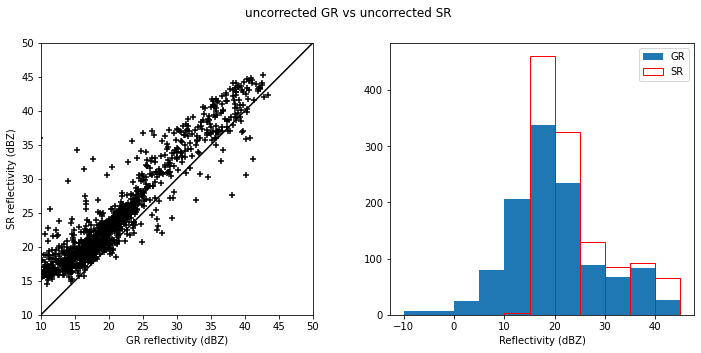

In [42]:
fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, aspect="equal")
pl.scatter(refgr1, refsr1, marker="+", c="black")
pl.plot([0,60],[0,60], linestyle="solid", color="black")
pl.xlim(10,50)
pl.ylim(10,50)
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
ax = fig.add_subplot(122)
pl.hist(refgr1[refsr1>10], bins=np.arange(-10,50,5), edgecolor="None", label="GR")
pl.hist(refsr1[refsr1>-10], bins=np.arange(-10,50,5), edgecolor="red", facecolor="None", label="SR")
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
fig.suptitle("uncorrected GR vs uncorrected SR")

Text(0.5, 0.98, 'corrected GR vs uncorrected SR')

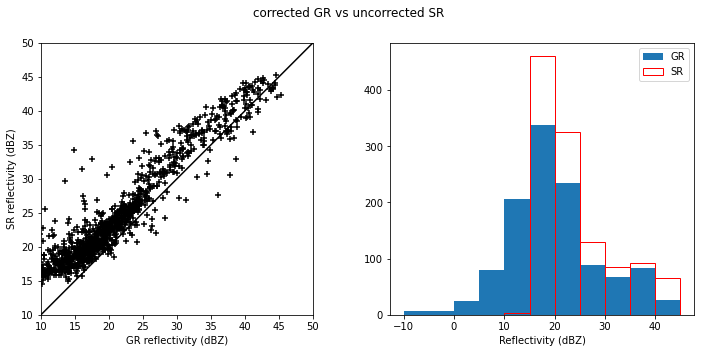

In [43]:
fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, aspect="equal")
pl.scatter(refgr2, refsr1, marker="+", c="black")
pl.plot([0,60],[0,60], linestyle="solid", color="black")
pl.xlim(10,50)
pl.ylim(10,50)
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
ax = fig.add_subplot(122)
pl.hist(refgr1[refsr1>10], bins=np.arange(-10,50,5), edgecolor="None", label="GR")
pl.hist(refsr1[refsr1>-10], bins=np.arange(-10,50,5), edgecolor="red", facecolor="None", label="SR")
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
fig.suptitle("corrected GR vs uncorrected SR")

Text(0.5, 0.98, 'corrected GR vs corrected SR snow')

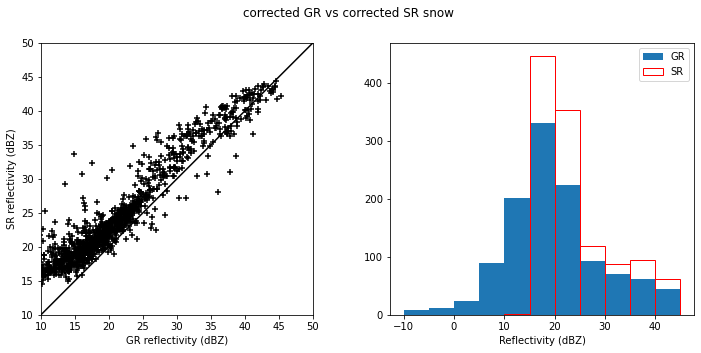

In [44]:
fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, aspect="equal")
pl.scatter(refgr2, refsr2, marker="+", c="black")
pl.plot([0,60],[0,60], linestyle="solid", color="black")
pl.xlim(10,50)
pl.ylim(10,50)
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
ax = fig.add_subplot(122)
pl.hist(refgr2[refsr2>10], bins=np.arange(-10,50,5), edgecolor="None", label="GR")
pl.hist(refsr2[refsr2>-10], bins=np.arange(-10,50,5), edgecolor="red", facecolor="None", label="SR")
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
fig.suptitle("corrected GR vs corrected SR snow")

Text(0.5, 0.98, 'corrected GR vs corrected SR hail')

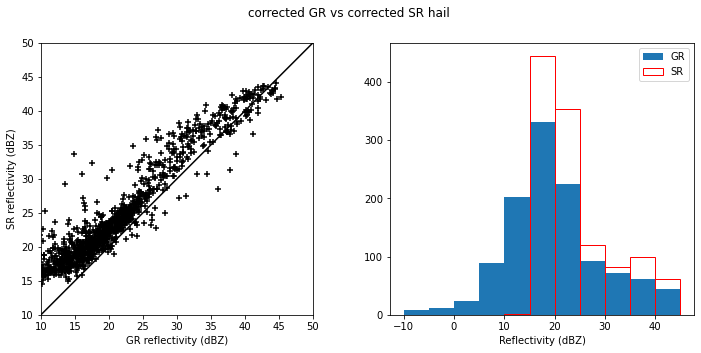

In [45]:
fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, aspect="equal")
pl.scatter(refgr2, refsr3, marker="+", c="black")
pl.plot([0,60],[0,60], linestyle="solid", color="black")
pl.xlim(10,50)
pl.ylim(10,50)
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
ax = fig.add_subplot(122)
pl.hist(refgr2[refsr3>10], bins=np.arange(-10,50,5), edgecolor="None", label="GR")
pl.hist(refsr3[refsr3>-10], bins=np.arange(-10,50,5), edgecolor="red", facecolor="None", label="SR")
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
fig.suptitle("corrected GR vs corrected SR hail")

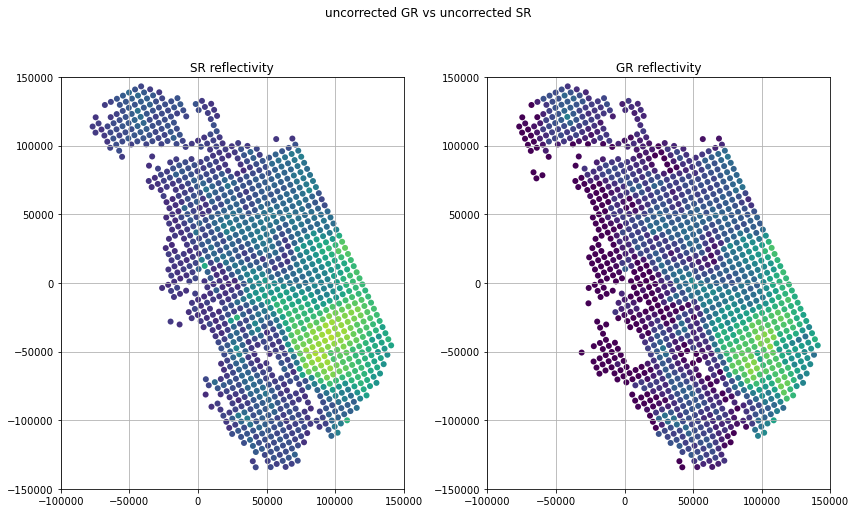

In [46]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(121, aspect="equal")
pl.scatter(x, y, c=refsr1, cmap=pl.cm.viridis, vmin=10, vmax=50, edgecolor="None")
pl.title("SR reflectivity")
pl.xlim(-100000, 150000)
pl.ylim(-150000, 150000)
pl.grid()
ax = fig.add_subplot(122, aspect="equal")
pl.scatter(x, y, c=refgr1, cmap=pl.cm.viridis, vmin=10, vmax=50, edgecolor="None")
pl.title("GR reflectivity")
pl.xlim(-100000, 150000)
pl.ylim(-150000, 150000)
pl.grid()
fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()